In [1]:
dataframe <- read.csv(file = "../donnees_meteo_synop.csv", header = TRUE, sep = ";")

In [5]:
head(dataframe)

,ID.OMM.station,Date,Pression.au.niveau.mer,Variation.de.pression.en.3.heures,Type.de.tendance.barométrique,Direction.du.vent.moyen.10.mn,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,⋯,Altitude,communes..name.,communes..code.,EPCI..name.,EPCI..code.,department..name.,department..code.,region..name.,region..code.,mois_de_l_annee
,<int>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,7181,2016-07-12T11:00:00+02:00,101410,-30,8,230,2.9,293.35,286.55,65,⋯,336,Thuilley-aux-Groseilles,54523,CC du Pays de Colombey et du Sud Toulois,245400510,Meurthe-et-Moselle,54,Grand Est,44,7
2,81405,2017-01-08T07:00:00+01:00,101140,-140,8,240,0.5,297.25,296.25,94,⋯,4,Matoury,97307,CA du Centre Littoral,249730045,Guyane,973,Guyane,3,1
3,7627,2017-01-08T13:00:00+01:00,103380,-40,8,30,2.1,277.55,269.75,57,⋯,414,Lorp-Sentaraille,09289,CC Couserans-Pyrénées,200067940,Ariège,09,Occitanie,76,1
4,78894,2017-01-09T13:00:00+01:00,101760,0,NA,100,2.3,298.15,291.35,66,⋯,44,,,,NA,,,,NA,1
5,7020,2017-01-12T13:00:00+01:00,100580,-710,8,210,11.9,282.05,280.15,88,⋯,6,La Hague,50041,CA du Cotentin,200067205,Manche,50,Normandie,28,1
6,7280,2017-12-23T13:00:00+01:00,103830,-10,0,10,2.7,280.75,278.35,85,⋯,219,Ouges,21473,Dijon Métropole,242100410,Côte-d'Or,21,Bourgogne-Franche-Comté,27,12


# ACP et PLS

On a de nombreuses variables et on voudrait résumer toutes les informations dans un plus petit nombre de variables. On suppose que certaines observations se ressemblent, notamment pour les observations d'un même endroit proches dans le temps. Certaines variables permettent d'expliquer la variabilité globale. 

Pour visualiser et interpréter la structure globale de notre jeu de données, on peut utiliser l'Analyse en Composantes Principales (ACP).

## 1. ACP

Pour faire une analyse en composantes principales (ACP), on utilise la fonctio `prcomp()` et on stocke le résultat retourné dans un objet sur notre espace de travail.

`prcomp()` ne gère pas les NA : il faut alors netoyer les données avant de l'utiliser. On retire aussi les colonnes non numériques.

De plus, notre jeu de données étant très lourd, on doit optimiser la mémoire utilisée pour ne pas faire crasher notre kernel. La fonction `prcomp_irlba()` du package `irlba` permet de faire une ACP tronquée, c'est à dire qu'on ne calcule que les premières composantes principales. C'est souvent suffisant pour avoir une bonne idée de la structure des données.

```r



In [6]:
library(data.table)

# Sélection des colonnes numériques :
num_cols <- names(dataframe)[sapply(dataframe, is.numeric)]
X <- dataframe[, num_cols]

cat("Numériques initiales :", length(num_cols), "\n")
cat("Taille objet X :", format(object.size(X), units="MB"), "\n")

# Sélection des colonnes sans NA (seuil 40%)
keep_na <- colMeans(is.na(X)) < 0.40
X <- X[, keep_na]
cat("Après filtre NA (<40%) :", ncol(X), "colonnes\n")

# Sélection des colonnes à variance positive
v_sd <- sapply(X, function(v) sd(v, na.rm=TRUE))
X <- X[, v_sd > 0]
cat("Après filtre variance :", ncol(X), "colonnes\n")

# Échantillonnage à cause de la taille de notre fichier de données
if (nrow(X) > 80000) {
  set.seed(42)
  sel <- sample(nrow(X), 80000)
  X <- X[sel, ]
  cat("Échantillon: 80000 lignes\n")
}

# Imputation simple (médiane) au lieu de complete.cases pour éviter pertes massives + copies
for (j in seq_len(ncol(X))) {
  if (anyNA(X[,j])) {
    med <- suppressWarnings(median(X[,j], na.rm=TRUE))
    if (is.finite(med)) X[is.na(X[,j]), j] <- med
  }
}
cat("NA restants après imputation :", sum(is.na(X)), "\n")

cat("Taille objet avant PCA :", format(object.size(X), units="MB"), "\n")

# Conversion en matrice 
Xm <- as.matrix(X)

# ACP tronquée 
if (!requireNamespace("irlba", quietly=TRUE)) install.packages("irlba")
library(irlba)
k <- min(20, ncol(Xm) - 1)  # nombre de composantes souhaitées, on en prend 20 
pc_irlba <- prcomp_irlba(scale(Xm, center=TRUE, scale=TRUE), n = k)
cat("Composantes calculées (irlba):", k, "\n")

# Variance expliquée
var_exp <- pc_irlba$sdev^2 / sum(pc_irlba$sdev^2)
print(round(var_exp[1:10] * 100, 2))


Numériques initiales : 64 
Taille objet X : 688.8 Mb 
Après filtre NA (<40%) : 31 colonnes
Après filtre variance : 31 colonnes
Échantillon: 80000 lignes
NA restants après imputation : 0 
Taille objet avant PCA : 16.5 Mb 


Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.3.3”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


Composantes calculées (irlba): 20 
 [1] 15.47 12.91 11.37  7.87  6.06  5.79  5.25  4.77  3.66  3.41


In [7]:
# Quelques vérifications
cat("Classe de l'objet :", class(pc_irlba), "\n")
cat("Type de l'objet :", mode(pc_irlba), "\n")
cat("Test du type 'list' :", is.list(pc_irlba), "\n")

Classe de l'objet : irlba_prcomp prcomp 
Type de l'objet : list 
Test du type 'list' : TRUE 


La fonction `summary()` permet d'avoir un résumé de l'ACP avec notamment des informations sur chaque composante principale (comme on a utilisé une  ACP tronquée, on n'a pas la même sortie que pour une ACP classique, seulement 20 composantes sont calculées).

In [8]:
summary(pc_irlba)

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     2.1405 1.9559 1.8356 1.5269 1.34004 1.30941 1.24670
Proportion of Variance 0.1478 0.1234 0.1087 0.0752 0.05793 0.05531 0.05014
Cumulative Proportion  0.1478 0.2712 0.3799 0.4551 0.51301 0.56832 0.61846
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.18906 1.04114 1.00555 0.97154 0.94567 0.90843 0.88426
Proportion of Variance 0.04561 0.03497 0.03262 0.03045 0.02885 0.02662 0.02522
Cumulative Proportion  0.66407 0.69904 0.73165 0.76210 0.79095 0.81757 0.84279
                          PC15    PC16    PC17    PC18    PC19    PC20
Standard deviation     0.86089 0.81013 0.79513 0.75679 0.69647 0.63825
Proportion of Variance 0.02391 0.02117 0.02039 0.01848 0.01565 0.01314
Cumulative Proportion  0.86670 0.88787 0.90827 0.92674 0.94239 0.95553

**L'éboulis des valeurs propres** permet de visualiser la variance expliquée par chaque composante principale :

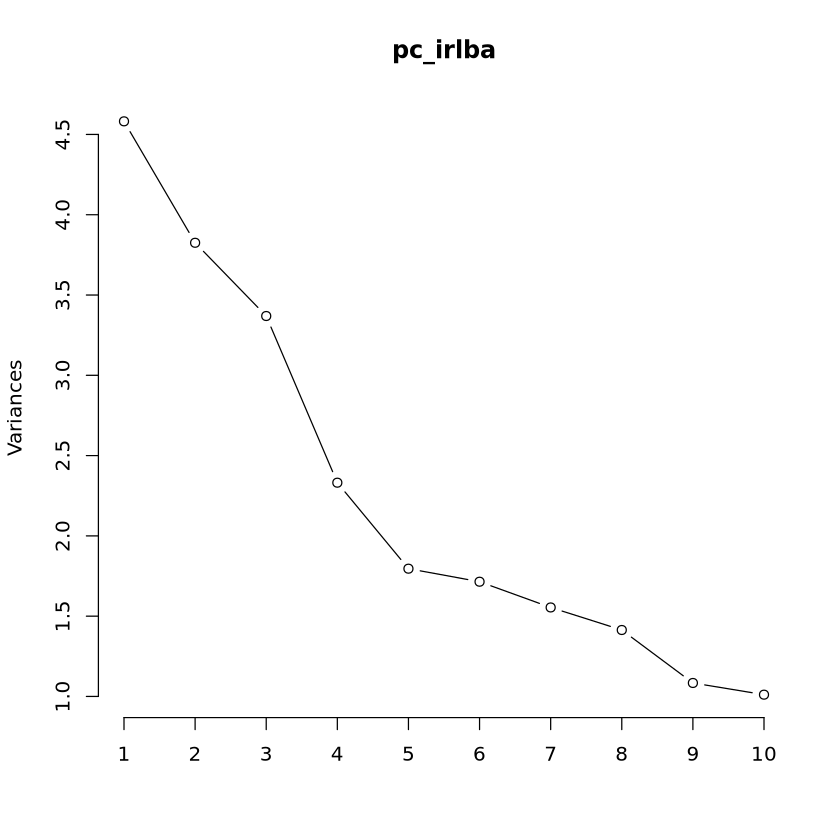

In [9]:
plot(pc_irlba, type="l")

Pour déterminer le nombre de variables raisonnable de retenir à partir de l'éboulis, on utilise la **règle du coude** : on regarde où l'éboulis commence à se stabiliser. Ici, on remarque que la pente de la courbe change à partir de la 5ème composante principale. On peut donc retenir les 4 premières composantes principales.

On trace ensuite les **biplots**. On a retenu 4 composantes principales. Chaque biplot est un plan 2D formé par une paire de composantes. Comme un biplot ne peut montrer que 2 axes à la fois, on explore plusieurs plans pour utiliser nos 4 composantes choisies. On trace donc les plans PC1-PC2, PC1-PC3, PC2-PC3 et PC3-PC4.


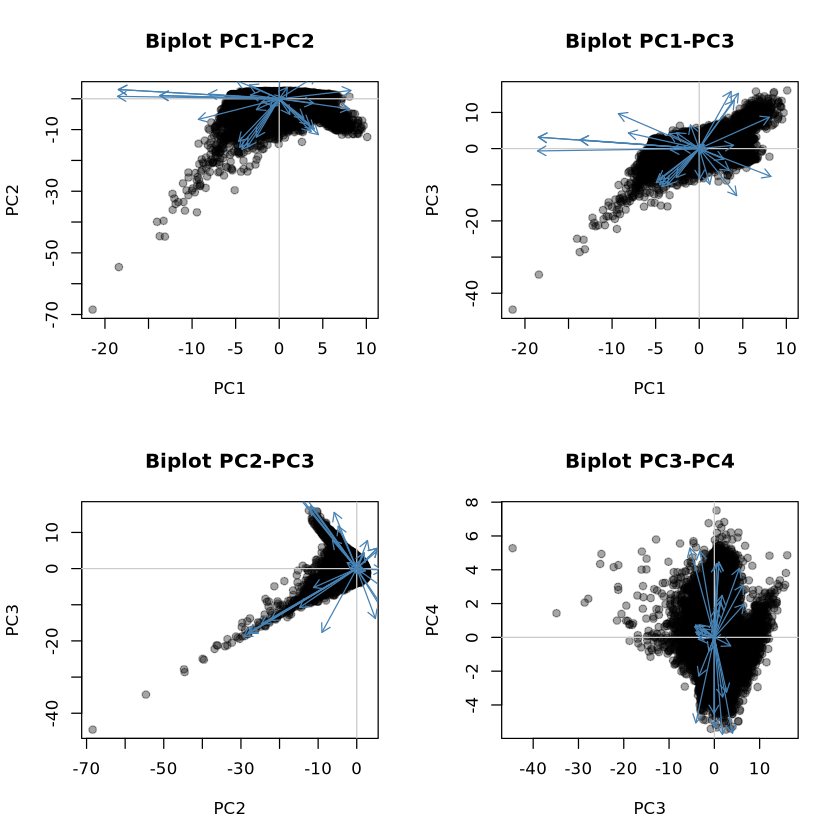

In [10]:
# Fonction biplot simple pour objet prcomp/prcomp_irlba
biplot_pc <- function(pca, axes = c(1,2), scale_arrows = 0.85, col_points = rgb(0,0,0,0.35)) {
  sc <- pca$x[, axes]
  ld <- pca$rotation[, axes]
  # Mise à l'échelle des flèches
  rng_sc <- apply(sc, 2, range)
  rng_ld <- apply(ld, 2, range)
  mult <- min( (diff(rng_sc[,1]) / diff(rng_ld[,1])),
               (diff(rng_sc[,2]) / diff(rng_ld[,2])) ) * scale_arrows
  ld2 <- ld * mult
  plot(sc,
       xlab = paste0("PC", axes[1]),
       ylab = paste0("PC", axes[2]),
       main = paste0("Biplot PC", axes[1], "-PC", axes[2]),
       pch = 19, col = col_points)
  abline(h=0,v=0,col="gray80")
  arrows(0,0, ld2[,1], ld2[,2], length=0.08, col="steelblue")
  text(ld2[,1], ld2[,2], labels = rownames(ld), col="steelblue4", cex=0.7, pos=3)
}

# Paires de plans à afficher
plans <- list(c(1,2), c(1,3), c(2,3), c(3,4))

op <- par(mfrow=c(2,2))
for (ax in plans) biplot_pc(pc_irlba, axes = ax)
par(op)


Les plans choisis montrent bien que les 4 premières composantes sont principales car chaque graphe apporte de l'information. Comme on a déjà pris le temps de traiter (centrage) les données, on n'a pas besoin de faire un traitement supplémentaire après visualisation des graphes. On peut ainsi réduire la dimension de notre jeu de données. 

Malheureusement, le volume important de données surcharge les graphes malgré l'échantillonnage. On ne peut pas vraiment voir de structure claire dans les données.

Une autre méthode pour faire une ACP serait de prendre un échantillon représentatif de nos données mais plus petit que le jeu initial et d'utiliser `prcomp()` classique. 

Pour des données météo, on peut sélectionner pour chaque station une donnée par mois ou par semaine par exemple (en faisant une moyenne) pour diminuer la taille du jeu de données.



On se demande ensuite si on peut prédire une variable météo cible (par exemple la température) à partir des autres variables explicatives. il existe peut-être des relations linéaires entre la variable cible et certaines variables explicatives. Mais cela nécessite aussi d'identifer les variables les plus pertinentes pour prédire la variable cible.

Pour construire un modèle prédictif linéaire en présence de nombreuses variables potentiellement corrélées, on utilise la méthode de **la régression PLS (Partial Least Squares)**.

## 2. PLS

On décide de prédire la température à partir des autres variables météo. 

On doit d'abord sélectioner les variables explicatives pertinentes. Puis on nettoie les données avant de faire la PLS. 


In [2]:
library(pls)


Attaching package: ‘pls’


The following object is masked from ‘package:stats’:

    loadings




In [3]:
y_name <- grep("Température", names(dataframe), value=TRUE)[1]  # ex: "Température"
cat("Variable cible:", y_name, "\n")

Variable cible: Température 


On nettoie nos données pour être sûr d'avoir uniquement des variables numériques et sans NA. On échantillone pour ne pas faire un PSL complet sur 1.7 millions de lignes.

In [4]:
num_cols <- names(dataframe)[sapply(dataframe, is.numeric)]
if (! y_name %in% num_cols) {
  stop("La variable cible n'est pas numérique. Vérifiez son nom.")
}
df_num <- dataframe[, num_cols]

# Échantillonnage
set.seed(123)
n_target <- min(150000, nrow(df_num))
sel <- sample(nrow(df_num), n_target)
df_samp <- df_num[sel, ]

# Partage en données d'entraînement et de test
set.seed(123)
idx_train <- sample(seq_len(nrow(df_samp)), floor(0.8 * nrow(df_samp)))
train <- df_samp[idx_train, ]
test  <- df_samp[-idx_train, ]

# On retire les colonnes de variance nulle dans le jeu d'entraînement
pred_cols <- setdiff(names(train), y_name)
if (length(pred_cols) == 0) stop("Aucun prédicteur disponible.")

# Imputation médiane (sur les données d'entraînement) puis application aux données de test
for (nm in pred_cols) {
  if (anyNA(train[[nm]])) {
    med <- suppressWarnings(median(train[[nm]], na.rm=TRUE))
    if (is.finite(med)) train[[nm]][is.na(train[[nm]])] <- med
  }
  # Appliquer même médiane au test
  if (anyNA(test[[nm]])) {
    if (!exists("med") || !is.finite(med)) med <- suppressWarnings(median(train[[nm]], na.rm=TRUE))
    if (is.finite(med)) test[[nm]][is.na(test[[nm]])] <- med
  }
}

# Écarts-types robustes
v_sd_train <- sapply(train[, pred_cols, drop=FALSE],
                     function(v) suppressWarnings(sd(v, na.rm=TRUE)))

# Colonnes entièrement NA ou longueur 1 -> sd NA -> traiter comme 0
v_sd_train[is.na(v_sd_train)] <- 0
keep_pred <- v_sd_train > 0

if (any(!keep_pred)) {
  drop_vars <- pred_cols[!keep_pred]
  cat("Colonnes retirées (variance nulle ou NA):", paste(drop_vars, collapse=", "), "\n")
  train <- train[, c(y_name, pred_cols[keep_pred])]
  test  <- test[,  c(y_name, pred_cols[keep_pred])]
  pred_cols <- pred_cols[keep_pred]
}

cat("Prédicteurs restants après filtre variance:", length(pred_cols), "\n")

# Formule
form <- as.formula(paste(y_name, "~ ."))

# Détermination sûre de ncomp max
p <- ncol(train) - 1              # nb prédicteurs
nobj <- nrow(train)               # nb observations
ncomp_max <- min(25, p, nobj - 1) # contrainte PLS
if (ncomp_max < 2) stop("Pas assez d'observations pour calculer >1 composante.")

cat("Prédicteurs:", p, " | Observations:", nobj, " | ncomp_max:", ncomp_max, "\n")

# Modèle PLS avec CV (k segments)

mod_pls <- plsr(form,
                data = train,
                ncomp = ncomp_max,
                scale = TRUE,
                validation = "CV",
                segments = 7,
                segment.type = "random")



Colonnes retirées (variance nulle ou NA): Niveau.barométrique 
Prédicteurs restants après filtre variance: 62 
Prédicteurs: 62  | Observations: 120000  | ncomp_max: 25 


In [5]:
summary(mod_pls)

Data: 	X dimension: 118481 62 
	Y dimension: 118481 1
Fit method: kernelpls
Number of components considered: 25

VALIDATION: RMSEP
Cross-validated using 7 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           9.325    4.401    2.498    1.712     1.17   0.8229   0.6645
adjCV        9.325    4.400    2.497    1.712     1.17   0.8228   0.6643
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV      0.5845   0.5403   0.5306    0.5235    0.5109    0.4869    0.4585
adjCV   0.5843   0.5402   0.5306    0.5238    0.5113    0.4870    0.4586
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps  20 comps
CV       0.4222    0.3783    0.3080    0.2306    0.1538   0.09954   0.05409
adjCV    0.4222    0.3782    0.3078    0.2304    0.1533   0.09904   0.05365
       21 comps  22 comps  23 comps  24 comps  25 comps
CV      0.03414   0.02722   0.02321   0.02150   0.02066
adjCV   0.03381   0.02699   0.02264   0.02133   0.

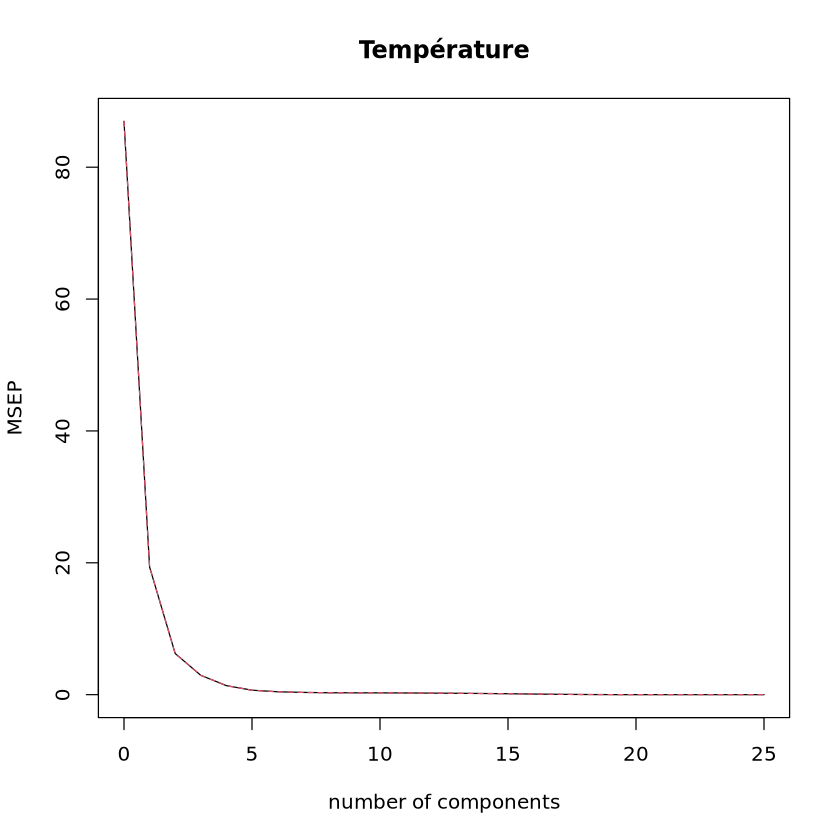

In [6]:
validationplot(mod_pls, val.type = "MSEP")

La courbe de validation croisée (CV) permet de choisir le nombre optimal de composantes latentes (ncomp) à retenir dans le modèle PLS en montrant l'erreur de prédiction (MSEP) en fonction du nombre de composantes.

Dans notre cas, on remarque que l'erreur de prédiction diminue rapidement jusqu'à 5 composantes puis se stabilise. On peut donc choisir de retenir 5 composantes dans notre modèle PLS.


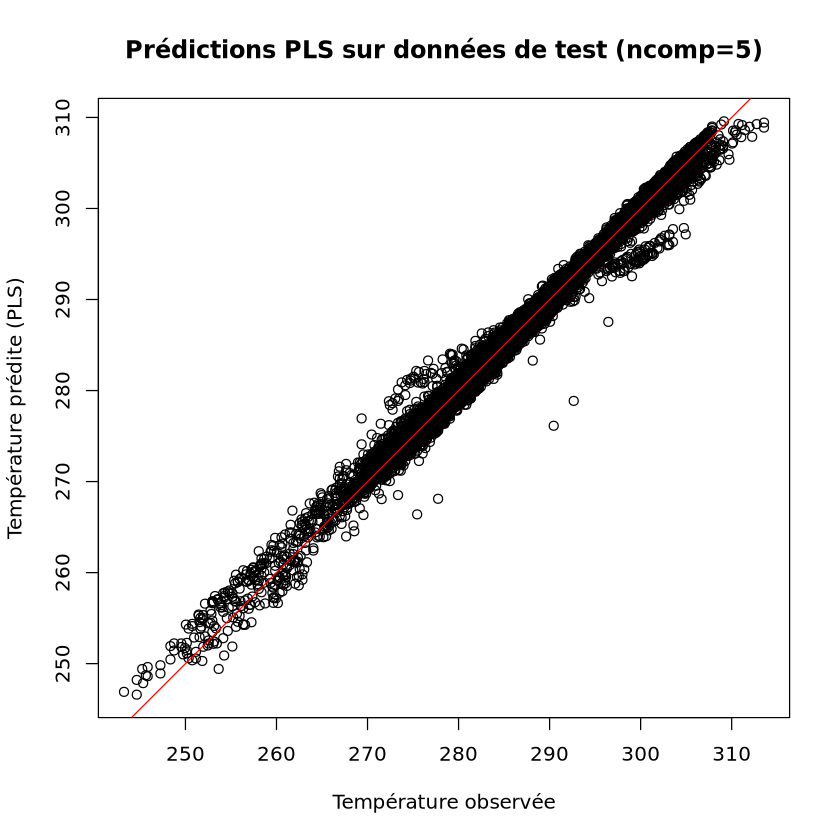

In [7]:
pred_pls <- predict(mod_pls, newdata = test, ncomp = 5)  

plot(test$`Température`, pred_pls,
     xlab = "Température observée",
     ylab = "Température prédite (PLS)",
     main = "Prédictions PLS sur données de test (ncomp=5)")
abline(0,1,col="red")

Notre nuage de point est aligné sur la diagonale (y = x), ce qui indique que les prédictions du modèle PLS sont correctes vis à vis des valeurs observées de la température. Le modèle semble donc bien fonctionner pour prédire la température à partir des autres variables météo.

On retrouve quelques points en décalage mais comme ce n'est pas systématique, on pourrait plutôt penser à du bruit dans les données.

On peut compléter ce résultat avec une analyse des résides (les différences entre les valeurs observées et les valeurs prédites).

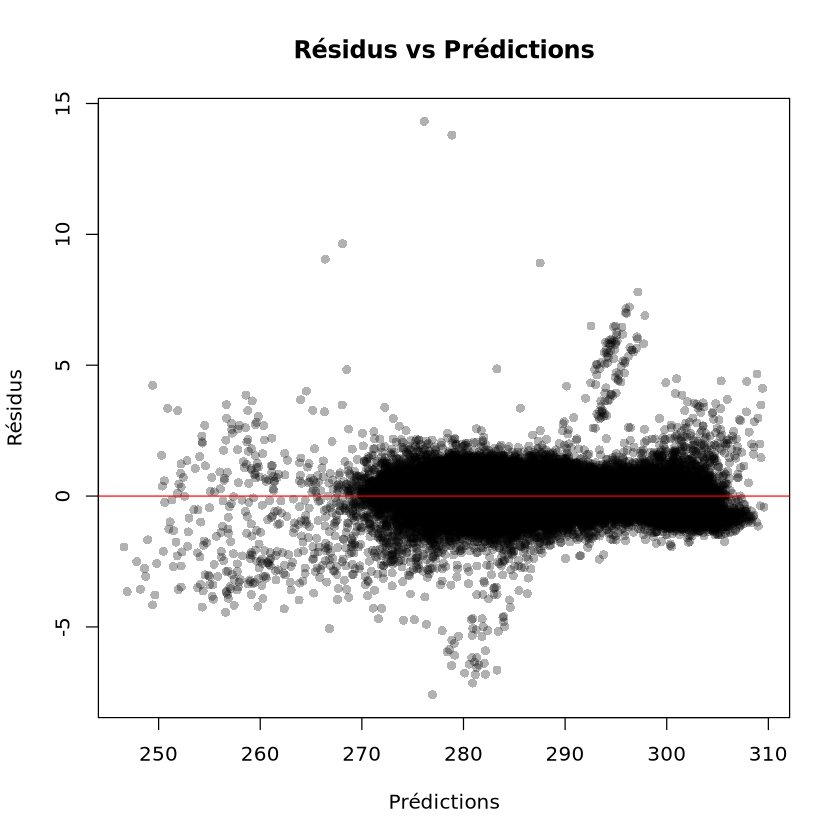

In [10]:
# Résidus
y_obs <- test$`Température`
y_pred <- as.vector(pred_pls)

res <- y_obs - y_pred

plot(y_pred, res,
     pch=16, col=rgb(0,0,0,0.3),
     xlab="Prédictions", ylab="Résidus",
     main="Résidus vs Prédictions")
abline(h=0,col="red")



On a bien un nuage centré autour de 0, ce qui est bon signe. On ne remarque pas de structure particulière dans les résidus, ce qui est aussi un bon signe. On retrouve quand même quelques points très éloignés (outliers) mais ils viennent peut-être de conditions météos atypiques sur nos données initiales.

Pour conclure, la courbe de validation croisée (CV) nous a permis de déterminer le nombre de composantes nécessaires pour notre modèle PLS. On a vu que les 5 premières composantes expliquaient 99% de la variance totale. On utilise alors notre modèle PLS avec 5 composantes pour prédire la température. Le nuage de points des valeurs prédites en fonction des valeurs observées montre que le modèle fonctionne bien : le nuage est aligné sur la diagonale. Le graphe des résidus centré autour de 0 confirme l'hypothèse de linéarité. On a ainsi construit un modèle de prédiction de la température à partir des autres variables météo.

Notre modèle a ses limites. Certaines données météo atypiques (orages, tempêtes, etc.) peuvent ne pas être bien prédites par le modèle. De plus, on a utilisé un échantillon des données pour construire le modèle PLS. Un échantillon plus grand pourrait améliorer les performances du modèle mais augmenterait aussi le temps de calcul. 